# Recommendation Engine For IBM Watson Studio Blog Articles

In this notebook, I will create a recommendation engine for users of the IBM Watson Studio platform. This engine will provide new articles for the user, no matter if the user is new or have already interacted with the platform.
Therefore, I will use the following algorithms:
- Ranked-Based
- User-Based
- Matrix Factorization (FunkSVD)

## Table Of Contents 

#### 1. [Exploratory Data Analysis](#eda)  
#### 2. [Ranked-Based Recommendation](#rbr)
#### 3. [User-Based Recommendation](#ubr)
#### 4. [Matrix Factorization Recommendation](#mfr)
#### 5. [Final Model](#fm)

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from collections import Counter

## <a class="anchor" id="eda"> 1. Exploratory Data Analysis </a>

### 1.1 Article Data

In [2]:
# load csv
df_articles  = pd.read_csv('articles_community.csv')

In [3]:
# view first 5 rows
df_articles.head()

,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
# view the shape of the dataframe
df_articles.shape

(1056, 6)

In [5]:
# show the data types
df_articles.dtypes

Unnamed: 0          int64
doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object

In [6]:
# show the statistical basic values for the numeric values
df_articles.describe()

,Unnamed: 0,article_id
count,1056.000000,1056.000000
mean,1607.390152,523.913826
std,958.121618,303.480641
min,3.000000,0.000000
25%,770.250000,260.750000
50%,1624.000000,523.500000
75%,2423.250000,786.250000
max,3281.000000,1050.000000


In this dataframe there are just 2 numeric values. The 'Unnamed: 0' values seems to be a random id column. It can be deleted.
The column 'article_id' seems to be the real id for the dataframe. The problem is that the position of this column isn't right. It needs to be on the first position.

In [7]:
# delete column 'Unnamed: 0'
df_articles = df_articles.drop('Unnamed: 0', axis=1)

In [8]:
# rerange the columns
col = list(df_articles.columns)
col = col[-1:] + col[:-1]
df_articles = df_articles[col]

In [9]:
# number of unique values of the categorical columns
for column in list(df_articles.columns):
    print(column)
    print(len(df_articles[column].unique()))

article_id
1051
doc_body
1037
doc_description
1023
doc_full_name
1051
doc_status
1


In [10]:
# find all values in the categorical columns, which appears more the once
# count the number of them
dict_multi_val = {}
for column in list(df_articles.columns):
    dict_multi_val[column] = {}
    if len(df_articles[column].unique()) > 1 and len(df_articles[column].unique()) < df_articles.shape[0]:
        for unique_value in df_articles[column].unique():
            if len(df_articles[df_articles[column]==unique_value].index) > 1:
                dict_multi_val[column][unique_value] = len(df_articles[df_articles[column]==unique_value].index)      

dict_multi_val

{'article_id': {50: 2, 221: 2, 232: 2, 398: 2, 577: 2},
 'doc_body': {'Working Vis * \r\n * \r\n\r\n * Home\r\n * About This Blog\r\n * Brunel': 4,
  '* Select a country/region: United States\r\n\r\nIBM� * Site map\r\n\r\nSearch\r\n\r\n * Related materials Download\r\n\r\n * NO RELATED MATERIALS FOUND\r\n   \r\n\r\n * \r\n * \r\n * \r\n * \r\n * \r\n\r\n * LinkedIn\r\n * Google+\r\n * Twitter\r\n * Facebook\r\n\r\n * \r\n\r\n * Related materials\r\n\r\n * NO RELATED MATERIALS FOUND\r\n   \r\n\r\n * Download\r\n\r\n * \r\n * \r\n * \r\n * \r\n\r\n * \r\n\r\n * Download\r\n\r\n\r\nCONTACT IBM\r\nCONSIDERING A PURCHASE?\r\n * Email IBM\r\n\r\nFOOTER LINKS\r\n * Contact\r\n * Privacy\r\n * Terms of use\r\n * Accessibility': 2,
  'Cheat sheet': 2,
  'Need to report the video?\r\n\r\nSign in to report inappropriate content.\r\n\r\nSign in\r\n\r\nWant to watch this again later?\r\n\r\nSign in to add this video to a playlist.\r\n\r\nSign in\r\n\r\nSign in to make your opinion count.\r\n\r\nSig

In [11]:
# find if the rows with multi ids are the same as with the multi values in the other columns
pd.set_option('display.max_colwidth',None) # set the amount of text per column which is shown
for ids in dict_multi_val['article_id']:
    print('-------------')
    print(ids)
    print('-------------')
    print(df_articles[df_articles['article_id']==ids])

-------------
50
-------------
     article_id  \
50           50   
365          50   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Here is my analysis of the multi ids:
- id 50: not the same articles
- id 221: duplicates
- id 232: duplicates
- id 398: duplicates
- id 577: duplicates

Also, it seems that the 'doc body' is the whole text of the articles. 

The 'doc_decription' is a short abstract, and the 'doc_full_name' is the name of the article.

The column doc_status tells me if the article is still online.

The duplicates can be deleted. The reason therefore is that this can cause problems with the matrix factorization. For example, if the same user interact or rate the same article differently, then the latent vectors can be optimized in a wrong direction.

One of the articles with the id 50 needs another id. I give one of them the id 1057.

In [12]:
# show that the id number is not occupied 
df_articles.loc[df_articles['article_id'] == 1057]

,article_id,doc_body,doc_description,doc_full_name,doc_status


In [13]:
# find the index for changing the id
df_articles[df_articles['article_id'] == 50].index

Int64Index([50, 365], dtype='int64')

In [14]:
# change the article id
df_articles['article_id'].loc[365] = 1057

In [15]:
# delete all rows with duplicates in 'article_id'
df_articles = df_articles.drop_duplicates(subset='article_id', keep='first')

In [16]:
# find all values in the categorical columns, which appears more the once
# count the number of them
# do it again to see if some other count numbers have changed
dict_multi_val = {}
for column in list(df_articles.columns):
    dict_multi_val[column] = {}
    if len(df_articles[column].unique()) > 1 and len(df_articles[column].unique()) < df_articles.shape[0]:
        for unique_value in df_articles[column].unique():
            if len(df_articles[df_articles[column]==unique_value].index) > 1:
                dict_multi_val[column][unique_value] = len(df_articles[df_articles[column]==unique_value].index) 

dict_multi_val

{'article_id': {},
 'doc_body': {'Working Vis * \r\n * \r\n\r\n * Home\r\n * About This Blog\r\n * Brunel': 4,
  '* Select a country/region: United States\r\n\r\nIBM� * Site map\r\n\r\nSearch\r\n\r\n * Related materials Download\r\n\r\n * NO RELATED MATERIALS FOUND\r\n   \r\n\r\n * \r\n * \r\n * \r\n * \r\n * \r\n\r\n * LinkedIn\r\n * Google+\r\n * Twitter\r\n * Facebook\r\n\r\n * \r\n\r\n * Related materials\r\n\r\n * NO RELATED MATERIALS FOUND\r\n   \r\n\r\n * Download\r\n\r\n * \r\n * \r\n * \r\n * \r\n\r\n * \r\n\r\n * Download\r\n\r\n\r\nCONTACT IBM\r\nCONSIDERING A PURCHASE?\r\n * Email IBM\r\n\r\nFOOTER LINKS\r\n * Contact\r\n * Privacy\r\n * Terms of use\r\n * Accessibility': 2,
  'Cheat sheet': 2,
  'Need to report the video?\r\n\r\nSign in to report inappropriate content.\r\n\r\nSign in\r\n\r\nWant to watch this again later?\r\n\r\nSign in to add this video to a playlist.\r\n\r\nSign in\r\n\r\nSign in to make your opinion count.\r\n\r\nSign in to make your opinion count.': 2}

Some of the multi values disappear.

This means that at least all multi values of the column 'doc_body' can be deleted.

In [17]:
# delete all duplicates in the column 'doc_body'
df_articles = df_articles.drop_duplicates(subset='doc_body')

In [18]:
# find all values in the categorical columns, which appears more the once
# count the number of them
# do it again to see if some other count numbers have changed
dict_multi_val = {}
for column in list(df_articles.columns):
    dict_multi_val[column] = {}
    if len(df_articles[column].unique()) > 1 and len(df_articles[column].unique()) < df_articles.shape[0]:
        for unique_value in df_articles[column].unique():
            if len(df_articles[df_articles[column]==unique_value].index) > 1:
                dict_multi_val[column][unique_value] = len(df_articles[df_articles[column]==unique_value].index) 

dict_multi_val

{'article_id': {},
 'doc_body': {},
 'doc_description': {'Here’s this week’s news in Data Science and Big Data.': 10,
  'Here’s this week’s news in Data Science and Big Data. ': 16,
  'How to use the Spark machine learning programming model in IBM Analytics for Apache Spark on IBM Bluemix': 2,
  'Interesting data science links from around the web.': 2,
  'Every two weeks, we find the most interesting data science links from around the web and collect them in Data Science Briefings, the DataMiningApps newsletter.': 2,
  'In my last blog “Business differentiation through Machine Learning” I introduced and described the concepts of machine learning. We traced its origins from a computer science project to Watson show…': 2,
  'How to build SQL Queries in a Scala notebook using IBM Analytics for Apache Spark': 2},
 'doc_full_name': {'Graph-based machine learning': 2},
 'doc_status': {}}

The last multi values in the columns aren´t clear duplicates. That´s why I will not delete them.

In [19]:
# find out if the values, which appears several times, fill the gap between the number of 
# unique values and the total amount of rows
for key_outer in dict_multi_val:
    if key_outer != 'doc_status':
        sum_multi = 0
        count_values = 0
        for key_inner in dict_multi_val[key_outer]:
            sum_multi += dict_multi_val[key_outer][key_inner]
            count_values += 1
    
        delta = df_articles.shape[0] - (len(df_articles[key_outer].unique()) + sum_multi - count_values)
        print('The delta for the column {} to the number of rows in the Dataframe is {}'.format(key_outer, delta))

The delta for the column article_id to the number of rows in the Dataframe is 0
The delta for the column doc_body to the number of rows in the Dataframe is 0
The delta for the column doc_description to the number of rows in the Dataframe is 2
The delta for the column doc_full_name to the number of rows in the Dataframe is 0


It is clear that the columns 'doc_description' has some values which don't appear.
May they are NaN values?

In [20]:
# show the NaN numbers
nan_number = []
list_columns = list(df_articles.columns)
for column in list_columns:
    nan = df_articles[column].isna().sum()
    nan_number.append(nan)
    
nan_number

[0, 1, 3, 0, 0]

My assumption was right. The last values are NaN values.
The next step is to show the rows of these values to understand why there is no value.

In [21]:
# show the rows where a NaN values appears
for column in list(df_articles.columns):
    if df_articles[column].isna().sum() > 0:
        print('-------------')
        print(column)
        print('-------------')
        print(df_articles[df_articles[column].isna()])
        

-------------
doc_body
-------------
     article_id doc_body  \
206         206      NaN   

                                                                                                                                                             doc_description  \
206  Watch how to convert XML data to CSV format to load into dashDB. This video shows a tool called Convert XML to CSV found here: http://www.convertcsv.com/xml-to-csv.htm   

                 doc_full_name doc_status  
206  Load XML data into dashDB       Live  
-------------
doc_description
-------------
     article_id  \
354         354   
768         765   
919         916   

                                                                                                                                                                                                                                                                                                                                                        

The NaN value in column 'doc_body' can be deleted, because an article without any content is not read. 
It can be that this is an error in the csv file and this articles is existing. Because this is just one row, I will delete it.

The other NaN values can stay, because, that this articles just don't have a description. I will change the NaN values with an empty string.

In [22]:
# delete nan rows of the column 'doc_body'
df_articles = df_articles.dropna(subset=['doc_body'])

In [23]:
# change the nan values of 'doc_description' to empty strings
df_articles.loc[354, 'doc_description'] = ''
df_articles.loc[768, 'doc_description'] = ''
df_articles.loc[919, 'doc_description'] = ''

### 1.2 User-Item Interactions Data

In [24]:
# load csv
df_interaction = pd.read_csv('user-item-interactions.csv')

In [25]:
# view first 5 rows
df_interaction.head()

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


Here are my observations:
- 'Unnamed: 0': some kind of index => Can be deleted
- 'article_id': the article id like in the previous csv => Seems to be a float
- 'title': probably the title of the article
- 'email': anonymized email of a use which probably read or clicked on the article

In [26]:
# delete 'Unnamed: 0'
df_interaction = df_interaction.drop('Unnamed: 0', axis=1)

In [27]:
# show column types
df_interaction.dtypes

article_id    float64
title          object
email          object
dtype: object

Let´s look at the article data at first.

In [28]:
# convert 'article_id' in integer
df_interaction['article_id'] = df_interaction['article_id'].astype('int')

In [29]:
# show the number of rows
df_interaction.shape[0]

45993

In [30]:
# number of unique values of the categorical columns
for column in list(df_interaction.columns):
    print(column)
    print(len(df_interaction[column].unique()))

article_id
714
title
714
email
5149


In [31]:
# find all unique values in the categorical columns and count the frequency of them 
dict_multi_val = {}
for column in list(df_interaction.columns):
    dict_multi_val[column] = {}
    if len(df_interaction[column].unique()) > 1 and len(df_interaction[column].unique()) < df_interaction.shape[0]:
        for unique_value in df_interaction[column].unique():
            if len(df_interaction[df_interaction[column]==unique_value].index) > 0:
                dict_multi_val[column][unique_value] = len(df_interaction[df_interaction[column]==unique_value].index)      

In [32]:
# get the key/value variables
labels = list(dict_multi_val['article_id'].keys())
values = list(dict_multi_val['article_id'].values())

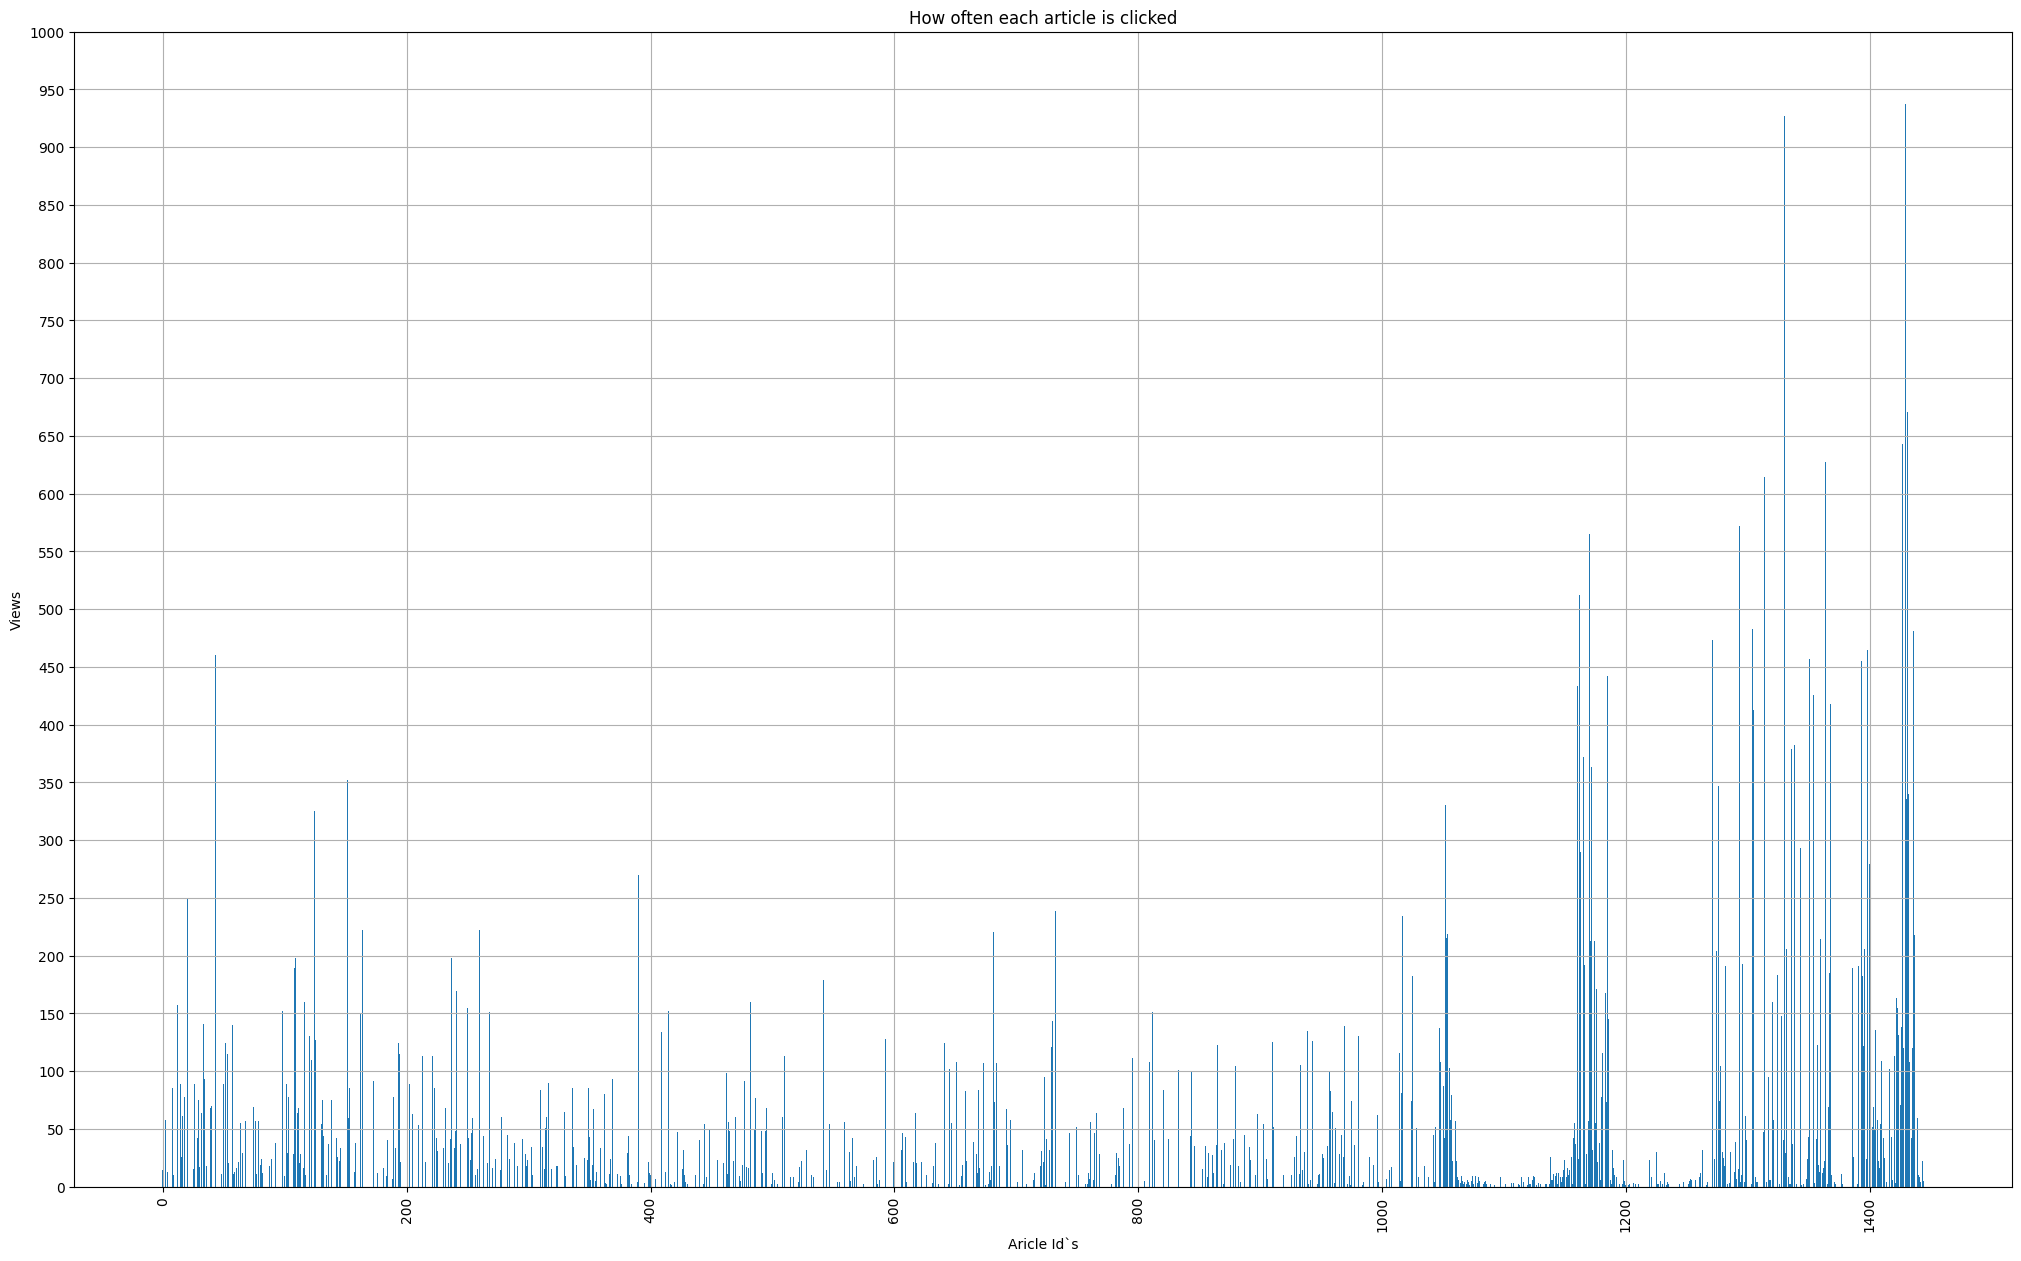

In [33]:
# visual how often each article is clicked
plt.figure(figsize=(25, 15))
plt.bar(labels, values)
plt.yticks(list(range(0, 1001, 50)))
plt.xlabel('Aricle Id`s')
plt.ylabel('Views')
plt.title('How often each article is clicked')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

There are some very popular articles with more to 600 views. Most articles are in the area between 50 and 500.
Let's describe this with numbers.

In [34]:
# some statistical values for views
print("Mean: ", statistics.mean(values))
print("Median: ", statistics.median(values))
print("Standard deviation: ", statistics.stdev(values))

Mean:  64.41596638655462
Median:  25.0
Standard deviation:  109.17592284477693


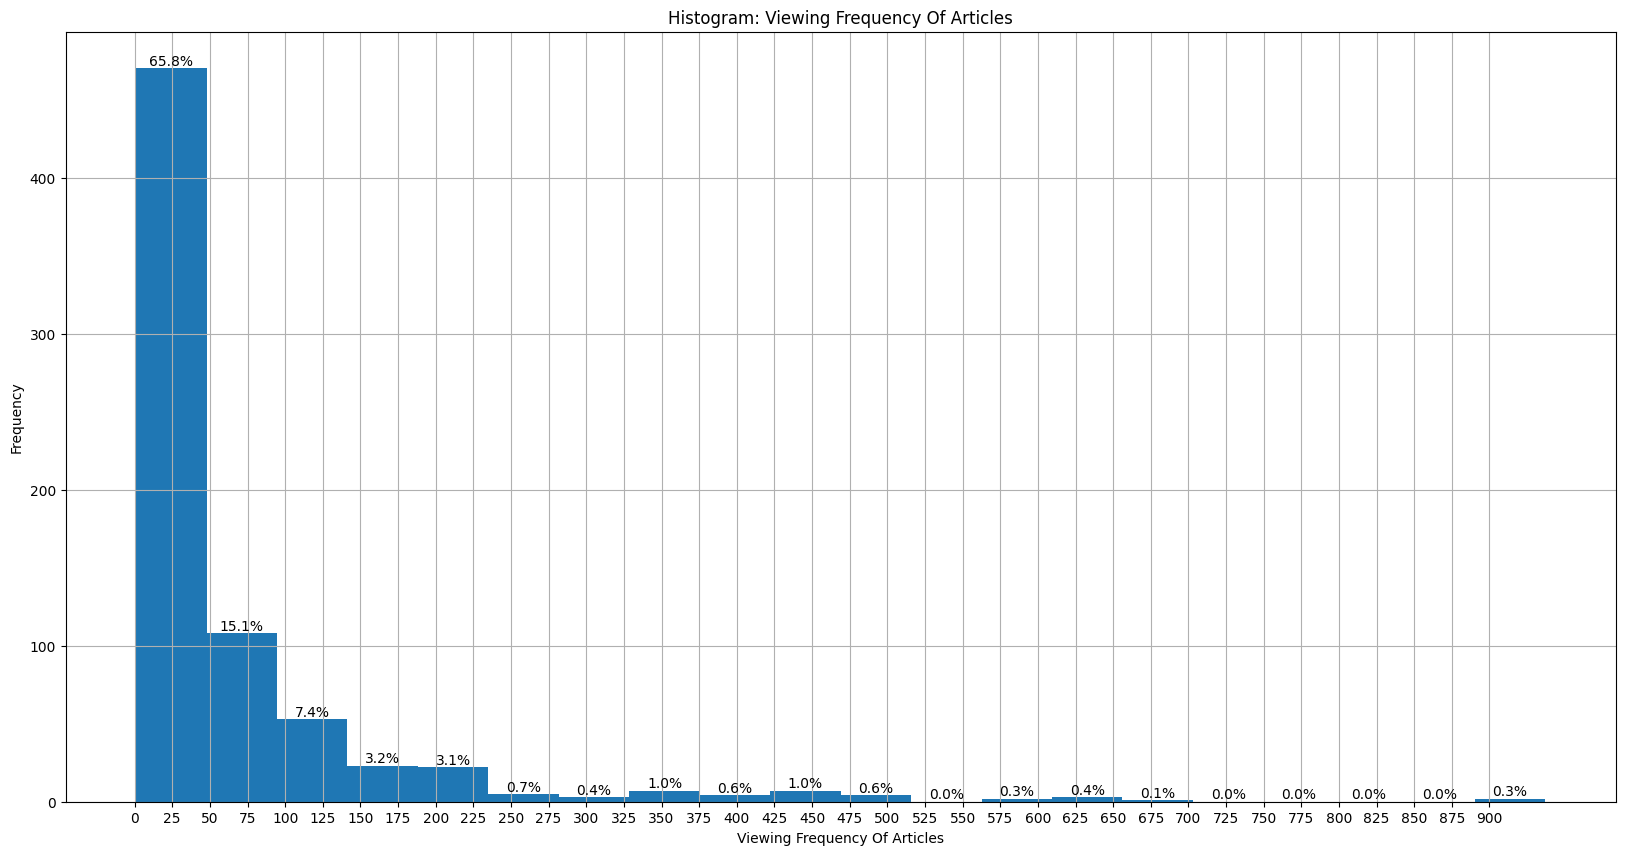

In [35]:
# show histogram of articles

# define the plt size
plt.figure(figsize=(20, 10))

# x label
plt.xlabel('Viewing Frequency Of Articles')

# y label
plt.ylabel('Frequency')

# titel
plt.title('Histogram: Viewing Frequency Of Articles')

# change the segmentation
plt.xticks(list(range(0, 901, 25)))

# Create histogram
plt.hist(values, bins=20)

# Get histogram counts and bins
counts, bins = np.histogram(values, bins=20)

# Compute bin widths and centers
widths = bins[1:] - bins[:-1]
centers = (bins[1:] + bins[:-1]) / 2

# Compute percentages
percents = counts / len(values) * 100

# Add percentages to the histogram
for i, percent in enumerate(percents):
    plt.text(centers[i], counts[i], f"{percent:.1f}%", ha='center', va='bottom')
    
# show grid
plt.grid(True)

# Show plot
plt.show()

About 80% of articles were viewed 80 times of the users. Just about 5% of the articles are viewed more to 300 times.

How about the videos with no views?

In [36]:
# Show the numbers of articles with no views
dict_min_val = {}
for column in list(df_interaction.columns):
    dict_min_val[column] = {}
    if len(df_interaction[column].unique()) > 0 and len(df_interaction[column].unique()) < df_interaction.shape[0]:
        for unique_value in df_interaction[column].unique():
            if len(df_interaction[df_interaction[column]==unique_value].index) == 0:
                dict_min_val[column][unique_value] = len(df_interaction[df_interaction[column]==unique_value].index)      

In [37]:
# show articles with no interactions
print(dict_min_val['article_id'])
print('')
print('The number of articles with no interaction are {}.'.format(len(dict_min_val['article_id'])))

{}

The number of articles with no interaction are 0.


There are no article that hasn't been viewed at all.

Now I do the same for the users to check how they interact with the articles.

In [38]:
# check how many users have just one or no interaction with the articles
counted_min = Counter(list(dict_min_val['email'].values()))
counted_min

Counter({0: 1})

There are is just one user with no interaction.

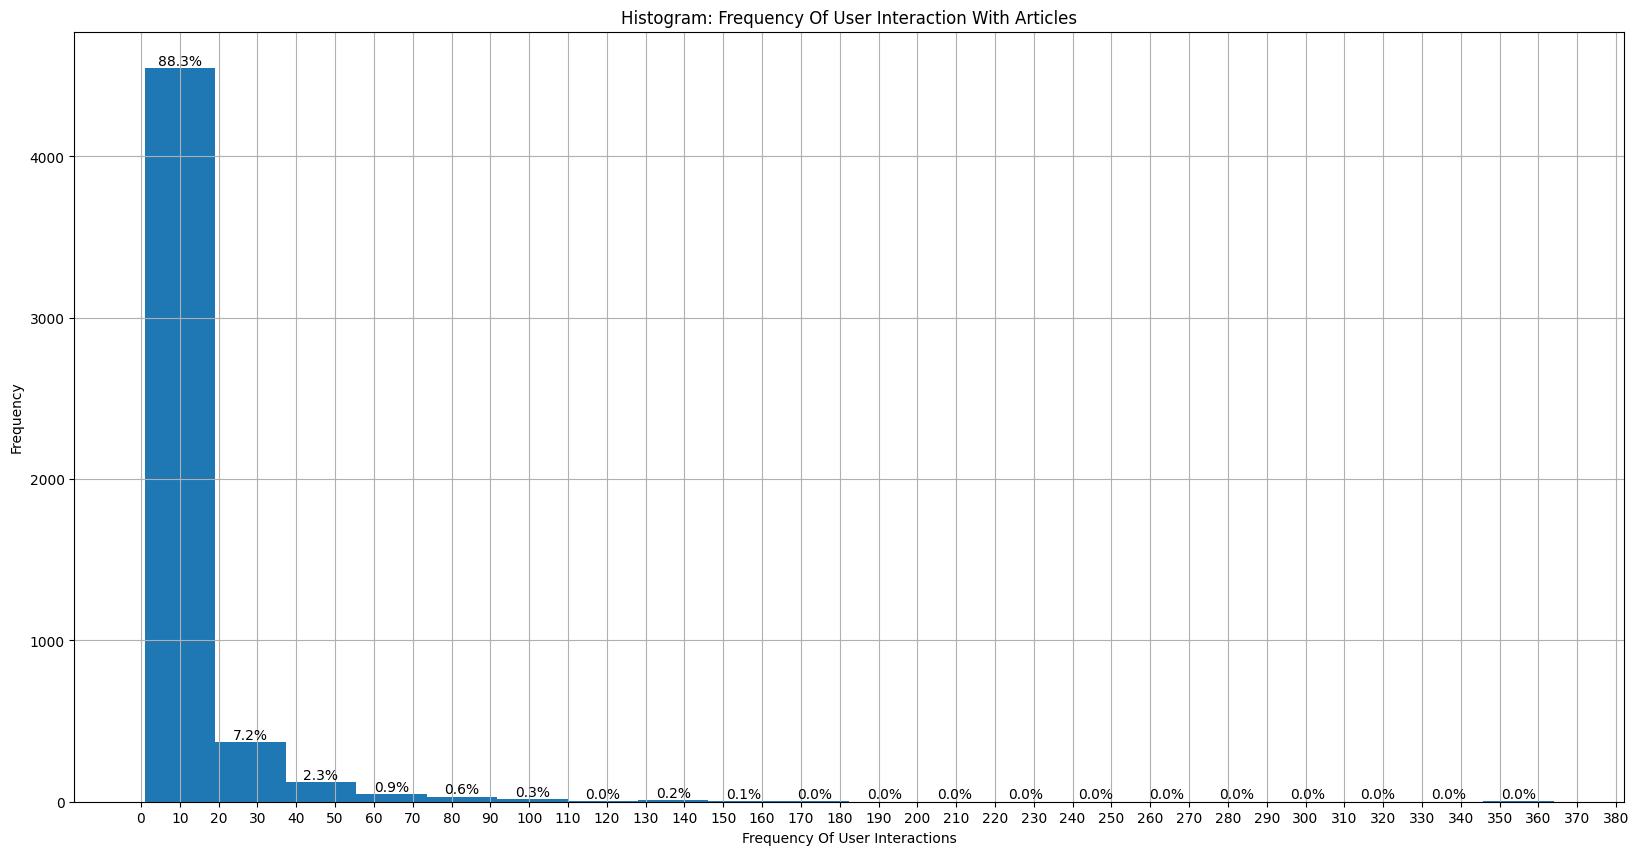

In [39]:
# visual a histogram with the user-article interaction

# define the plt size
plt.figure(figsize=(20, 10))

# x label
plt.xlabel('Frequency Of User Interactions')

# y label
plt.ylabel('Frequency')

# titel
plt.title('Histogram: Frequency Of User Interaction With Articles')

# change the segmentation
plt.xticks(list(range(0, 400, 10)))

# Create histogram
plt.hist(list(dict_multi_val['email'].values()), bins=20)

# Get histogram counts and bins
counts, bins = np.histogram(list(dict_multi_val['email'].values()), bins=20)

# Compute bin widths and centers
widths = bins[1:] - bins[:-1]
centers = (bins[1:] + bins[:-1]) / 2

# Compute percentages
percents = counts / len(list(dict_multi_val['email'].values())) * 100

# Add percentages to the histogram
for i, percent in enumerate(percents):
    plt.text(centers[i], counts[i], f"{percent:.1f}%", ha='center', va='bottom')
    
# show grid
plt.grid(True)

# Show plot
plt.show()

The most users interacted with 1 to 20 articles. 

There is a very small amount of users which viewed more the 350 articles.

In [40]:
# show the nan values
nan_values = {}
list_columns = list(df_interaction.columns)
for column in list(df_interaction.columns):
    nan = df_interaction[column].isna().sum()
    nan_values[column] = nan
    
nan_values

{'article_id': 0, 'title': 0, 'email': 17}

In [41]:
# show the rows where a NaN values appears
for column in list(df_interaction.columns):
    if df_interaction[column].isna().sum() > 0:
        print('-------------')
        print(column)
        print('-------------')
        print(df_interaction[df_interaction[column].isna()])

-------------
email
-------------
       article_id  \
25131        1016   
29758        1393   
29759          20   
29760        1174   
29761          62   
35264         224   
35276         961   
35277         268   
35278         268   
35279         268   
35280         268   
35281         415   
35282         846   
35283         268   
35284         162   
42749         647   
42750         965   

                                                                       title  \
25131  why you should master r (even if it might eventually become obsolete)   
29758                                           the nurse assignment problem   
29759                working interactively with rstudio and notebooks in dsx   
29760                          breast cancer wisconsin (diagnostic) data set   
29761    data visualization: the importance of excluding unnecessary details   
35264                                       using apply, sapply, lapply in r   
35276                      

There is nothing special in the rows of the nan values. Because the email is necessary to make a prediction, the values can be deleted.

In [42]:
# delete nan rows
df_interaction = df_interaction.dropna(axis=0) 

In the next step, I will check which users viewed which articles more than once. Maybe there are user which looked at some article multiple times.

In [43]:
# find amount seen articles of each user
dict_dupli_user = {}
for user in list(df_interaction['email'].unique()):
    user_df = df_interaction[df_interaction['email'] == user]
    dict_dupli_user[user] ={}
    for article_id in list(user_df['article_id'].unique()):
        id_df = user_df[user_df['article_id'] == article_id]
        freq_id = len(id_df['article_id'])
        dict_dupli_user[user][article_id] = freq_id       

In [44]:
# because the values in the subset were not classified as duplicates based on the complete row, it's necessary to
# delete the empty entries
for outer_key in dict_dupli_user.copy():
    if dict_dupli_user[outer_key] == {}:
        del dict_dupli_user[outer_key]

In [45]:
# create list with the number of all articles a user read
uniq_art_user = []
for dict_ in list(dict_dupli_user.values()):
    uniq_art_user.append(len(dict_))

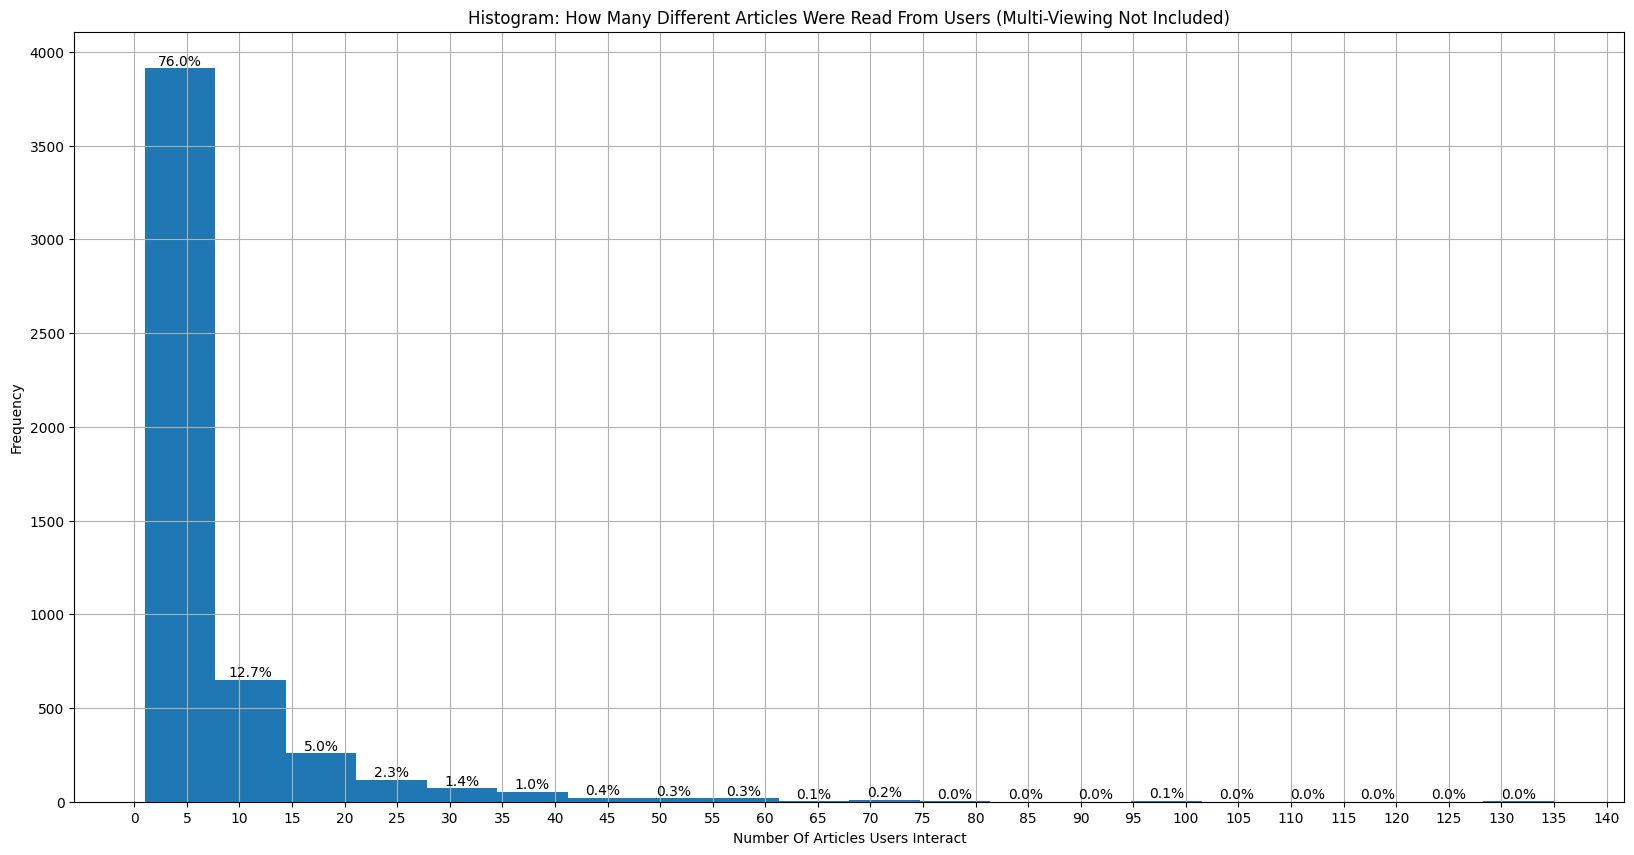

In [46]:
# visual a histogram of how many different articles were read from users (multi viewing not included)

# define the plt size
plt.figure(figsize=(20, 10))

# x label
plt.xlabel('Number Of Articles Users Interact')

# y label
plt.ylabel('Frequency')

# title
plt.title('Histogram: How Many Different Articles Were Read From Users (Multi-Viewing Not Included)')

# change the segmentation
plt.xticks(list(range(0, 150, 5)))

# Create histogram
plt.hist(uniq_art_user, bins=20)

# Get histogram counts and bins
counts, bins = np.histogram(uniq_art_user, bins=20)

# Compute bin widths and centers
widths = bins[1:] - bins[:-1]
centers = (bins[1:] + bins[:-1]) / 2

# Compute percentages
percents = counts / len(uniq_art_user) * 100

# Add percentages to the histogram
for i, percent in enumerate(percents):
    plt.text(centers[i], counts[i], f"{percent:.1f}%", ha='center', va='bottom')
    
# show grid
plt.grid(True)

# Show plot
plt.show()

We see that the most users viewed 1 to 7 different articles. Compared to the other graph, this means that 
the higher viewing number results through multi-viewing. 
That means that the average user interact with a relatively low number of articles.

These conclusions show me that I will probably have some problems with the matrix factorization.

## <a class="anchor" id="rbr"> 2. Ranked-Based Recommendation </a>

The next chapter is about the creation of a Ranked-Based Recommendation. 

First, I define a function which get me all top n articles. The definition of 'top' is to find the articles with the most clicks.

In [47]:
def get_top_articles(n, df_interaction):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df_interaction - the dataframe of the user-article interactions 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    top_articles_ids - (list) A list of the top 'n' article ids
    
    '''
    # create empty dictionary 
    dict_count = {}
    
    # iterate through all unique articles
    for unique_value in df_interaction['article_id'].unique():
        
        # check if the interactions are bigger than 0
        if len(df_interaction[df_interaction['article_id']==unique_value].index) > 0:
            
            # fill the dictionary with the number of interactions
            dict_count[unique_value] = len(df_interaction[df_interaction['article_id']==unique_value].index)   
            
    
    # sort the ids from many to few interactions 
    top_articles_ids = list(dict(sorted(dict_count.items(), key=lambda item: item[1], reverse=True)).keys())[:n]
    
    # create empty list
    top_articles = []
    
    # fill the list with the article names
    for article_id in top_articles_ids:
        top_articles.append(list(df_interaction[df_interaction['article_id']==article_id]['title'])[0])
    
    return top_articles, top_articles_ids

In [48]:
# test of the function for the top 5 articles
get_top_articles(5, df_interaction)

(['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm'],
 [1429, 1330, 1431, 1427, 1364])

With this algorithm, all users get the top n articles recommended. It needs to be considered that just the top n articles should be recommended, which the users didn´t read. This will be implemented in the finale code, where all 3 algorithms are combined. 

## <a class="anchor" id="ubr"> 3. User-Based Recommendation </a>

In the next step, I will create an algorithm which finds users with similar behavior and recommend articles which the one users didn't read but the other. 

To find similar behavior, I look at the articles a user has viewed and compare them to all users to find the user with the most matches. The items that the first user didn't see, but the similar user did, will be recommended.

In [49]:
# find users with more the 2 viewed articles
user_read_3 = []
for user in dict_dupli_user:
    if len(dict_dupli_user[user]) > 2:
        user_read_3.append(user)   

In [50]:
# change from the original number of user to the users, a User-Based Recommendation can apply 
print('There are {} unique user.'.format(len(dict_dupli_user)))
print('After searching for users with more than 2 viewed articles, there are {} users left.'.format(len(user_read_3)))
print('{} users can`t have a prediction with this algorithm.'.format(len(dict_dupli_user)-len(user_read_3)))

There are 5148 unique user.
After searching for users with more than 2 viewed articles, there are 2839 users left.
2309 users can`t have a prediction with this algorithm.


In [51]:
# create matrix where the number of article views from each user is the value
user_article_matrix = pd.DataFrame.from_dict(dict_dupli_user, orient='index')

# fill the nan values with 0
user_article_matrix.fillna(0, inplace=True)

In [52]:
# show the first 5 rows of the df
user_article_matrix.head()

,1430,732,1429,43,109,1232,310,1293,1406,329,...,870,1127,233,384,1235,1303,675,1247,1156,1233
ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8b6fb4bbb7a27b336ba35420bf58337d877455c7,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5e8b6eea25188b0516fc111a32daa59a4419f767,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ec123f6658890db92d7db29a04c03e5e2098fa43,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e,3.0,0.0,13.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
def get_top_sorted_article(article_list, df_interaction):
    '''
    INPUT:
    article_list - list of artilce ids
    df_interaction - (pandas dataframe) user-article interaction
    
            
    OUTPUT:
    top_sorted_df - (pandas dataframe) a dataframe with:
                    artilce_id- sorted article ids on num_interactions
                    title - article title
                    num_interactions - the viewed number by the user
     
    '''
    
    top_sorted_df = pd.DataFrame(columns=['article_id', 'title', 'num_interactions'])
    
    filtered_df = df_interaction[df_interaction['article_id'].isin(article_list)]
    
    for index, article_id in enumerate(article_list):
        view_freq  = len(filtered_df[filtered_df['article_id'] == article_id])
        top_sorted_df.loc[index, 'article_id'] = article_id
        top_sorted_df.loc[index, 'title'] = filtered_df[filtered_df['article_id'] == article_id]['title'].iloc[0]
        top_sorted_df.loc[index, 'num_interactions'] = view_freq
    

    top_sorted_df = top_sorted_df.sort_values('num_interactions', ascending=False)
    
    
    
    return top_sorted_df

In [54]:
def similar_user(user_id, user_article_matrix):
    '''
    INPUT:
    user - user id
    
    OUTPUT:
    sim_user - (list) list with the most similar user from the most similar to the most dissimilar 
    
    '''
    # all seen articles of an user 
    user1_article = dict_dupli_user[user_id].keys()
    
    # create new df
    df_user_sim = pd.DataFrame(columns=['user2', 'similarity'])
    
    # iterate through the user_id_matrix
    for index, user_id_matrix in enumerate(user_article_matrix.index):
        
        # skip if the user is the same as the input user
        if user_id_matrix == user_id:
            next
        
        # find all users which have seen the most number of the same articles
        else:
            user2_article = dict_dupli_user[user_id_matrix].keys()
            df_user_sim.loc[index, 'user2'] = user_id_matrix
            df_user_sim.loc[index, 'similarity'] = len(list(set(user2_article).intersection(set(user1_article))))
    
    # sort the similar users
    df_user_sim = df_user_sim.sort_values('similarity', ascending=False)
    
       
    return df_user_sim # return a list of the users in order from most to least similar

In [55]:
def user_based_rec(
    user_email, 
    dict_dupli_user, 
    lower_bound, 
    user_article_matrix, 
    num_rec):
    '''
    INPUT:
    user_email - the user email 
    dict_dupli_user - dictionary with all users, the seen articles and the number of interactions
    lower_bound - min. number of seen articles
    user_article_matrix - matrix with all users and all article ids. The values are the number of seen articles
    num_rec - number of recommendation for a user
    
    OUTPUT:
    recs - (list) A list of the top 'n' article titles recommended through similar user
    rec_names - (list) A list of the top 'n' article ids recommended through similar user
    
    '''
    
    # get the similar user, get his article ids and find the ids which user1 
    recs = []
    rec_names = []
    
    # find all seen articles
    article_user1 = list(dict_dupli_user[user_email].keys())
        
    # find similar user
    sim_user = similar_user(user_email, user_article_matrix)
    
    if len(dict_dupli_user[user_email]) >= lower_bound: # check if the new user seen more the x articles   
        for user2 in sim_user['user2']:
            if len(recs) >= num_rec:
                break
            else:
                # get article ids from similar user
                article_user2 = list(dict_dupli_user[user2].keys())
                
                # find the articles which the new user didn´t see
                new_articles = list(set(article_user2).difference(set(article_user1)))
            
                # find article which are most clicked
                sorted_df = get_top_sorted_article(new_articles, df_interaction)
                sorted_new_article_id = list(sorted_df['article_id'])  
                sorted_new_article_title = list(sorted_df['title'])
            
                 # add the recommendation 
                recs = recs + sorted_new_article_id
                rec_names = rec_names + sorted_new_article_title
                  
    
    return recs[:num_rec], rec_names[:num_rec]

In [56]:
# use the function
recs, rec_names = user_based_rec(
    'ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7', 
    dict_dupli_user, 
    2, 
    user_article_matrix, 
    3)
print(recs)
print(rec_names)

[1330, 1364, 1314]
['insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo']


With a Used-Based Recommendation, more than 50% of all users can have a recommendation. Because with this algorithm, there is no option for training. The only possibility is an A/B-Test. 

In an A/B test, we randomly divide users into two groups: a control group and a test group. The control group receives the current recommendation system, while the test group receives the new recommendation system. By comparing the performance of the two groups, we can determine the effectiveness of the new system.

The users for the A/B test should be assigned randomly to the different groups to ensure that the groups are as similar as possible. The random assignment should also be conducted in a way that ensures that each group contains a representative sample of users in terms of their characteristics and behaviors.

The metric that will be tracked during the experiment to check if the recommendations are successful will be the number of new viewed articles. This can be compared with the number of new viewed articles of the control group. 

The length of the experiment will depend on the number of users and the expected effect size of the new recommendation system. Generally, the experiment should be run long enough to collect a sufficient amount of data to achieve statistical significance, but not so long that the results become outdated. As a general rule, a few weeks to a few months might be a reasonable timeframe for an A/B test of a recommendation system.

## <a class="anchor" id="mfr"> 4. Matrix Factorization Recommendation </a>

The next recommendation algorithm will be based on the Matrix Factorization. Therefore, I use the famous FUNK-SVD algorithm.

The FUNK-SVD based on the splitting of a matrix in 3 matrices with latent factors. The problem with the normal SVD is that it can´t work with nan values, so objects which a user didn´t see jet. So solve this problem, the FUNK-SVD use just the existing rating of a user and updated the nan and all other values of the latent factors with it. This will be done so long until a minimum error is reached. 

In [57]:
# transform all values which are bigger than 0 to 1
# create a matrix which just show if an article was seen
user_article_matrix_ext = user_article_matrix.applymap(lambda x: 1 if x > 0 else np.nan)

In [58]:
# show the first 5 rows of the new matrix
user_article_matrix_ext.head()

,1430,732,1429,43,109,1232,310,1293,1406,329,...,870,1127,233,384,1235,1303,675,1247,1156,1233
ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8b6fb4bbb7a27b336ba35420bf58337d877455c7,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e8b6eea25188b0516fc111a32daa59a4419f767,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ec123f6658890db92d7db29a04c03e5e2098fa43,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
def create_train_test(df_interaction, training_size, user_article_matrix_ext):
    '''    
    INPUT:
    reviews - (pandas df) dataframe to split into train and test
    training_size - (int) number of rows in training set in percentage 
    user_article_matrix_ext - matrix with all users and all article ids. The values NAN for not seen and 1 for seen
    
    OUTPUT:
    training_df -  (pandas df) dataframe of the training set
    validation_df - (pandas df) dataframe of the test set
    '''
    
    # create the row number from the percentage
    training_size_num = round((df_interaction.shape[0]/100)*training_size)
    testing_size_num = df_interaction.shape[0] - training_size_num
    
    # split the dfs
    training_df = df_interaction[0:training_size_num]
    validation_df = df_interaction[training_size_num:training_size_num+testing_size_num]
    
    # create user-article matrix for the train and test data
    training_df_transformed = user_article_matrix_ext.loc[training_df['email'].unique(), training_df['article_id'].unique()]
    validation_df_transformed = user_article_matrix_ext.loc[validation_df['email'].unique(), validation_df['article_id'].unique()]
    
    return training_df, training_df_transformed, validation_df, validation_df_transformed

In [60]:
# create training and test dataset
train_df, training_df_transformed, val_df, validation_df_transformed = create_train_test(df_interaction, 50, user_article_matrix_ext)

I choose a smaller training set because I want to increase the number of examples in the validation set. The problem is, that I need the users which are in both sets (training and test). I increase the amount of these users when I increase the test set. 

In [61]:
def FunkSVD(training_df_transformed, latent_features, learning_rate, iters):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    user_article_matrix_ext - matrix with all users and all article ids. The values 0 for not seen an 1 for seen
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    article_mat - (numpy array) a latent feature by article matrix
    '''
    
    data_np = np.array(user_article_matrix_ext)
    
    # Set up useful values to be used through the rest of the function
    n_users = training_df_transformed.shape[0]
    n_articles = training_df_transformed.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(training_df_transformed))
    
    # initialize the user and article matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    article_mat = np.random.rand(latent_features, n_articles)
    
    # for each iteration
    for iteration in range(iters):

        # For each user-article pair
        for i in range(n_users):
            for j in range(n_articles):
                
                # if the rating exists
                if data_np[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = data_np[i, j] - np.dot(user_mat[i, :], article_mat[:, j])
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*article_mat[k, j])
                        article_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

    return user_mat, article_mat 

In [63]:
def find_intersection(value, matrix1, matrix2):
    '''    
    INPUT:
    value - the value to search for an intersection
    matrix1 - matrix 1 to find intersections
    matrix2 - matrix 2 to find intersections
    
    OUTPUT:
    row_inters - list of row values with intersections
    cols_inters - list of column values with intersections
    row_positions - list of row positions with intersections
    cols_positions - list of column positions with intersections
    '''
    
    mask = matrix1.eq(value)

    rows, cols = matrix1.any(axis=1), matrix1.any()
    cols_list = list(cols[cols].index)
    rows_list = list(matrix1.index[rows])
    
    row_inters = list(set(matrix2.index) & set(rows_list))
    cols_inters = list(set(matrix2.columns) & set(cols_list))
    
    row_positions = [matrix2.index.get_loc(idx) for idx in row_inters]
    cols_positions = [matrix2.columns.get_loc(idx) for idx in cols_inters]

    return row_inters, cols_inters, row_positions, cols_positions

In [64]:
row_inters, cols_inters, row_positions, cols_positions= find_intersection(1, validation_df_transformed, training_df_transformed)

In [65]:
# number of users which can be tested
print('The number of users in the training set is {}.'.format(training_df_transformed.shape[0]))
print('The number of users in the validation set is {}.'.format(validation_df_transformed.shape[0]))
print('The number of users where the FUNK-SVD can be applied is {}.'.format(len(row_inters)))

The number of users in the training set is 2791.
The number of users in the validation set is 2774.
The number of users where the FUNK-SVD can be applied is 417.


In [66]:
# create the iteration length/steps
num_latent_feats = np.arange(1,30,2)

# create empty lists
train_error_sum = []
test_error_sum = []
total_error = []

# find the intersections between train and test sets
row_inters, cols_inters, row_positions, cols_positions = find_intersection(1, validation_df_transformed, training_df_transformed)

# transform the train and test sets in arrays
user_article_train = np.array(training_df_transformed)
user_article_test = np.array(training_df_transformed.loc[row_inters])

for k in num_latent_feats:
    # restructure with k latent features
    user_mat, article_mat = FunkSVD(training_df_transformed, latent_features=k, learning_rate=0.005, iters=50)
    
    # take dot product
    user_article_train_preds = np.around(np.dot(user_mat, article_mat),3)
    user_article_test_preds = user_article_train_preds[row_positions]
 
    # computing difference in prediction value
    train_dif = np.subtract(user_article_train, user_article_train_preds)
    test_dif = np.subtract(user_article_test, user_article_test_preds)
    
    
    # training and testing error
    train_dif_squared = train_dif ** 2
    test_dif_squared = test_dif ** 2
    train_error =  np.nansum(train_dif_squared)/np.count_nonzero(train_dif)
    test_error = np.nansum(test_dif_squared)/np.count_nonzero(test_dif)
    
    # fill the lists with the different errors per iteration
    train_error_sum.append(train_error)
    test_error_sum.append(test_error)

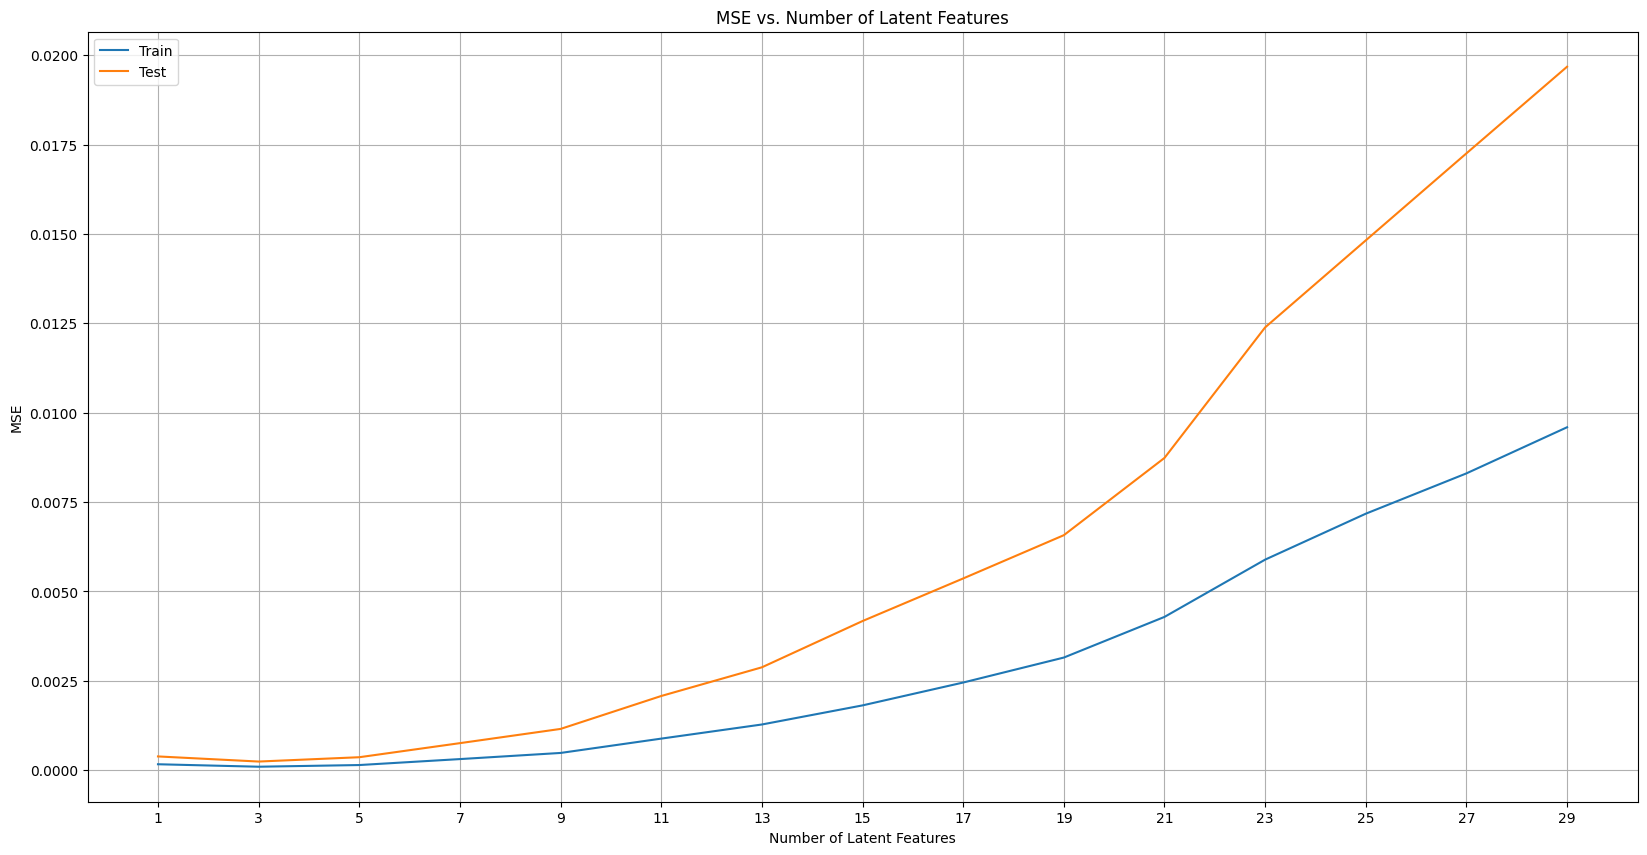

In [67]:
# plot the mean squared error on the number of latent factors

# define the plt size
plt.figure(figsize=(20, 10))

# plot train and test graphs
plt.plot(num_latent_feats, train_error_sum, label='Train')
plt.plot(num_latent_feats, test_error_sum, label='Test')

# labeling
plt.xlabel('Number of Latent Features')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Latent Features')

# define length and steps of the x-axis
plt.xticks(list(range(1, 30, 2)))

# active grid
plt.grid()

# show legend
plt.legend()

plt.show()
     


I have the smallest MSE in at the number of **3** latent factors. 

In the next step, I need to decide at which point of the float number in the prediction matrix if the article is a recommendation.

In [68]:
# show the summed MSE of the test data with the best latent feature
round(test_error_sum[2],6)

0.000363

For the beginning, I define the cut point at ± 0.000356.
If the final model don't generate enough recommendation, I will adjust the value to 2 * ± 0.000356.

## <a class="anchor" id="fm"> 5. Final Model </a>

The finale model will be a combination of all 3 algorithm. At first, I will use the FUNK-SVD. If the amount of recommendations is not enough, I will use the User-Based Recommendation. Finally, if I can't satisfy the amount of recommendation, I will use the Ranked-Based-Recommendation. 
For the 'Cold-Start-Problem' (complete new Users) I will only use the Ranked-Based-Recommendation.

In [69]:
# apply the FUNK-SVD
# restructure with k latent features
user_mat, article_mat = FunkSVD(user_article_matrix, latent_features=3, learning_rate=0.005, iters=50)

# prediction with FUNK-SVD
user_article_preds_funk_svd = np.around(np.dot(user_mat, article_mat),6)

In [70]:
# create a dictionary with all users and their seen articles (including the watch frequency)
seen_article = {}
for user in list(df_interaction['email'].unique()):
    user_df = df_interaction[df_interaction['email'] == user]
    seen_article[user] ={}
    for article_id in list(user_df['article_id'].unique()):
        id_df = user_df[user_df['article_id'] == article_id]
        freq_id = len(id_df['article_id'])
        seen_article[user][article_id] = freq_id  

In [71]:
# create matrix where the number of article views from each user is the value
user_article_matrix = pd.DataFrame.from_dict(seen_article, orient='index')
user_article_matrix = user_article_matrix.applymap(lambda x: 1 if x > 0 else np.nan)

In [72]:
def recommendation_engine(
    user_article_preds_funk_svd, 
    user_email, 
    seen_article, 
    database, 
    user_article_matrix,
    tolerance, 
    num_recs, 
    lower_bound
):
    '''    
    INPUT:
    user_article_preds_funk_svd - prediction matrix with FUNK-SVD
    user_email - user email
    seen_article - dictionary with all users, the seen articles and the number of interactions
    database - dataframe with article ids and user interactions
    user_article_matrix - matrix with all users and all article ids. The values NAN for not seen and 1 for seen
    tolerance - the selecting tolerance for the prediction values in user_article_preds_funk_svd
    num_recs - number of recommendations
    lower_bound - min. number of seen articles
    
    OUTPUT:
    rec_ids - (list) best 'n' article ids for the user
    rec_names - (list) best 'n' article names for the user
    '''
       
    # create empty list for recommendations
    rec_ids = []
    rec_names = []
    
    if user_email in user_article_matrix.index:
        
        # find the user position in the matrix
        pos_user = user_article_matrix.index.get_loc(user_email)
        
        funk_pred = user_article_preds_funk_svd[pos_user]
        funk_pred_tol = [
            idx for idx, rec in enumerate(funk_pred) 
            if rec <= 1+tolerance and rec >= 1-tolerance
        ]
        
        # transform array position in article id
        funk_pred_rec = [
            article for idx, article in enumerate(user_article_matrix.columns) if idx in funk_pred_tol
        ]
        
        # check which articles the user already seen
        diff_recs = list(set(funk_pred_rec).difference(set(seen_article[user_email].keys())))
        
        # add recommendations in list
        rec_ids.extend(diff_recs)
        
        # find the article names
        for article_id in rec_ids:
            rec_names.append(list(database[database['article_id']==article_id]['title'])[0])
            
        # if there are not enough recommendations, use the user-based recommendations
        if len(rec_ids) < num_recs:
            delta_rec = num_recs - len(rec_ids)
            user_based_rec_ids, user_based_rec_names = user_based_rec(
                user_email, seen_article, 
                lower_bound, 
                user_article_matrix, 
                delta_rec
            )
            
            # check which articles aren´t already recommended through FUNK-SVD
            user_based_rec_ids_new = list(set(user_based_rec_ids).difference(set(rec_ids)))
            user_based_rec_names_new = list(set(user_based_rec_names).difference(set(rec_names)))
            
            # add new articles
            rec_ids.extend(user_based_rec_ids_new)
            rec_names.extend(user_based_rec_names_new)
            
            # if there are not enough recommendations, use the ranked-based recommendations
            if len(rec_ids) < num_recs:
                delta_rec = num_recs - len(rec_ids)
                
                # use top ranked-based recommendation algorithm 
                ranked_rec_names, _ranked_rec_ids = get_top_articles(delta_rec, df_interaction)
                
                # check which articles aren´t already recommended through FUNK-SVD or user-based recommendation
                ranked_rec_ids_new = list(set(_ranked_rec_ids).difference(set(rec_ids)))
                ranked_rec_names_new = list(set(ranked_rec_names).difference(set(rec_names)))
                
                # add new articles
                rec_ids.extend(_ranked_rec_ids)
                rec_names.extend(ranked_rec_names)
    else:   
        # use top ranked-based recommendation algorithm if there is a complete new user
        rec_names, rec_ids = get_top_articles(num_recs, df_interaction)
    
    
    return rec_ids[:num_recs], rec_names[:num_recs]
        

In [73]:
# apply the function
recommendation_engine(
    user_article_preds_funk_svd, 
    'ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7', 
    seen_article,
    df_interaction, 
    user_article_matrix,
    0.000356, 
    10, 
    3
)

([993, 302, 658, 1171, 311, 184, 473, 1050, 1330, 1364],
 ['configuring the apache spark sql context',
  'accelerate your workflow with dsx',
  'automating web analytics through python',
  'apache spark lab, part 2: querying data',
  'probabilistic graphical models tutorial\u200a—\u200apart 2 – stats and bots',
  'improving the roi of big data and analytics through leveraging new sources of data',
  'intelligent applications - apache spark',
  'jupyter notebooks with scala, python, or r kernels',
  'insights from new york car accident reports',
  'predicting churn with the spss random tree algorithm'])